In [1]:
import pandas as pd
import geopandas as gpd
import os
import requests
import esda
import libpysal
import multiprocessing as mp
import itertools
import pygeos
import subprocess
import json
import sys

In [2]:
def resample_raster(rasterfile_path, filename, target_path, rescale_factor):
    # first determine pixel size for resampling
    xres = 0
    yres = 0
    
    out = subprocess.run(["gdalinfo","-json",rasterfile_path],stdout=subprocess.PIPE)
    raster_meta = json.loads(out.stdout.decode('utf-8'))
    if 'geoTransform' in raster_meta:
        xres = raster_meta['geoTransform'][1]
        yres = raster_meta['geoTransform'][5]
        xres = xres * rescale_factor
        yres = yres * rescale_factor

    if (xres != 0) and (yres != 0):
        # resample raster
        save_path = target_path +"/"+ filename + f"_resample_{rescale_factor}.tiff"
        subprocess.run(["gdalwarp","-r","bilinear","-of","GTiff","-tr",str(xres),str(yres),rasterfile_path,save_path])

        return save_path
    
def polygonize_fim(rasterfile_path):

    # Extract target path and filename from the given raster file path
    target_path = '/'.join(rasterfile_path.split('/')[:-1])
    filename = rasterfile_path.split("/")[-1].split(".")[-2]

    # Resample raster file to 10-times smaller
    resample_10_path = resample_raster(rasterfile_path, filename, target_path, rescale_factor=10)

    # Reclassify raster
    '''
    water_lvl = [0, 2, 6, 15, np.inf]  # Original inundation map value (underwater in feet)
    water_lvl_recls = [-9999, 1, 2, 3, 4]
    '''
    reclass_file = target_path + "/" + filename + "_reclass.tiff"
    outfile = "--outfile="+reclass_file
    subprocess.run(["gdal_calc.py","-A",resample_10_path,outfile,"--calc=-9999*(A<=0)+1*((A>0)*(A<=2))+2*((A>2)*(A<=6))+3*((A>6)*(A<=15))+4*(A>15)","--NoDataValue=-9999"],stdout=subprocess.PIPE)

    # Polygonize the reclassified raster
    geojson_out = "%s/%s.json" % (target_path, filename)
    subprocess.run(["gdal_polygonize.py", reclass_file, "-b", "1", geojson_out, filename, "value"])

    inund_polygons = gpd.read_file(geojson_out)
    inund_polygons = inund_polygons.loc[(inund_polygons['value'] != -9999) & (inund_polygons['value'] != 0)]  # Remove pixels of null value

    # drop invalid geometries
    inund_polygons = inund_polygons.loc[inund_polygons['geometry'].is_valid, :]

    # Coverage for each class of inundation map
    inund_per_cls = inund_polygons.dissolve(by='value')
    inund_per_cls.reset_index(inplace=True)

    # remove all temp files
    os.remove(resample_10_path)
    os.remove(reclass_file)
    os.remove(geojson_out)

    # inundation_per_cls: GeoDataFrame 
    return inund_per_cls

def fim_and_ellipse(dam_id, scene, input_dir):
        
    fim_path = f"./{input_dir}/{scenarios['loadCondition']}_{scenarios['breachCondition']}_{dam_id}.tiff"
    
    fim_gdf = polygonize_fim(fim_path)
    fim_gdf['Dam_ID'] = dam_id
    fim_gdf['Scenario'] = f"{scene['loadCondition']}_{scene['breachCondition']}"
        
    return fim_gdf

def state_num_related_to_fim(fim_gdf, tract_gdf):
    
    tract_geoms = pygeos.from_shapely(tract_gdf['geometry'].values)
    tract_geoms_tree = pygeos.STRtree(tract_geoms, leafsize=50)

    fim_geom_union = pygeos.from_shapely(fim_gdf['geometry'].unary_union)    
    query_intersect = tract_geoms_tree.query(fim_geom_union, predicate='intersects')
    tract_gdf = tract_gdf.loc[query_intersect]

    tract_gdf['STATE'] = tract_gdf.apply(lambda x:x['GEOID'][0:2], axis=1)
    unique_state = tract_gdf['STATE'].unique()
    
    # return type: list
    return unique_state
    
def extract_fim_geoid(dam_id, scene, input_dir, tract_gdf):
    print(f'{dam_id}: Step 1, 1/4, Identifying associated regions (Ellipse)')
    fim_gdf = fim_and_ellipse(dam_id, scene, input_dir)

    print(f'{dam_id}: Step 1, 2/4, Search states associated')
    fim_state = state_num_related_to_fim(fim_gdf, tract_gdf)
    print(f'-- {dam_id} impacts {len(fim_state)} States, {fim_state}')

    if len(fim_state) == 1: # If only one state is associated with the inundation mapping
        census_gdf = gpd.read_file(f'./census_geometry/tl_2020_{fim_state[0]}_tabblock20.geojson')
    elif len(fim_state) >= 2: # If multiple states are associated with the inundation mapping
        census_gdf = pd.DataFrame()
        for state_num in fim_state:
            temp_gdf = gpd.read_file(f'./census_geometry/tl_2020_{state_num}_tabblock20.geojson')
            census_gdf = pd.concat([temp_gdf, census_gdf]).reset_index(drop=True)
            census_gdf = gpd.GeoDataFrame(census_gdf, geometry=census_gdf['geometry'], crs="EPSG:4326")
    else:
        raise AttributeError('NO STATE is related to Inundation Mapping')

    # Destination dataframe to save the results
    print(f"{dam_id}: Step 1, 3/4, Extracting GEOID of census blocks")
    fim_geoid_df = pd.DataFrame({'Dam_ID': pd.Series(dtype='str'),
                                'Scenario': pd.Series(dtype='str'),
                                'GEOID': pd.Series(dtype='str'),
                                'Class': pd.Series(dtype='str')}
                                )    

    # Create STRtree for census_gdf
    census_geoms = pygeos.from_shapely(census_gdf['geometry'].values)
    census_geoms_tree = pygeos.STRtree(census_geoms, leafsize=50)

    # Extract census tract intersecting with each class of inundation map
    for water_cls in fim_gdf['value'].unique():
        fim_geom_ = pygeos.from_shapely(fim_gdf.loc[fim_gdf['value'] == water_cls, 'geometry'].values[0])
        query_fim_geom_ = census_geoms_tree.query(fim_geom_, predicate='intersects')
        fim_geoid_ = census_gdf.loc[query_fim_geom_]

        for geoid_ in fim_geoid_['GEOID'].to_list():
            new_row = pd.DataFrame({'Dam_ID': dam_id, 
                                    'Scenario': f"{scene['loadCondition']}_{scene['breachCondition']}", 
                                    'GEOID': geoid_, 
                                    'Class': water_cls}, 
                                    index=[0]
                                    )
            fim_geoid_df = pd.concat([new_row, fim_geoid_df]).reset_index(drop=True)

    print(f"{dam_id}: Step 1, 4/4, Assigning geometry to census blocks")
    fim_geoid_gdf = fim_geoid_df.merge(census_gdf, on='GEOID')
    fim_geoid_gdf = gpd.GeoDataFrame(fim_geoid_gdf, geometry=fim_geoid_gdf['geometry'], crs='EPSG:4326')
    fim_geoid_gdf['Class'] = fim_geoid_gdf['Class'].astype(int)
    fim_geoid_gdf = fim_geoid_gdf.groupby(['Dam_ID', 'Scenario', 'GEOID'], 
                                    group_keys=False).apply(lambda x:x.loc[x['Class'].idxmax()]
                                                            ).reset_index(drop=True)
    fim_geoid_gdf = fim_geoid_gdf.set_crs(epsg=4326)

    return fim_geoid_gdf, fim_gdf


In [5]:
cwd = os.getcwd()

scenarios = {'loadCondition': 'MH', 'breachCondition': 'F'}
input_dir = f'NID_FIM_{scenarios["loadCondition"]}_{scenarios["breachCondition"]}'
output_dir = f'{scenarios["loadCondition"]}_{scenarios["breachCondition"]}_Results'
API_Key = 'fbcac1c2cc26d853b42c4674adf905e742d1cb2b' # Census api key
tract_gdf = gpd.read_file(os.path.join(cwd, 'census_geometry', 'census_tract_from_api.geojson'))

# Find the list of dams in the input folder
fed_dams = pd.read_csv('./nid_available_scenario.csv')
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
# dois = fed_dams['ID'].to_list()
# dois = ['TX00009', 'TX00010', 'TX00011', 'TX00012'] 
dam_id = 'CA10104'


In [4]:
census_dic = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}


fim_geoid_gdf, fim_gdf = extract_fim_geoid(dam_id, scenarios, input_dir, tract_gdf)
fim_geoid_gdf
# mi_gdf, lm_gdf = spatial_correlation(dam_id, fed_dams, fim_geoid_gdf, census_dic, API_Key)

CA10104: Step 1, 1/4, Identifying associated regions (Ellipse)
Creating output file that is 51P x 30L.
Processing ./NID_FIM_MH_F/MH_F_CA10104.tiff [1/1] : 0Using internal nodata values (e.g. 0) for image ./NID_FIM_MH_F/MH_F_CA10104.tiff.
Copying nodata values from source ./NID_FIM_MH_F/MH_F_CA10104.tiff to destination ./NID_FIM_MH_F/MH_F_CA10104_resample_10.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90..Several drivers matching json extension. Using GeoJSON
Creating output ./NID_FIM_MH_F/MH_F_CA10104.json of format GeoJSON.
.100 - done.
CA10104: Step 1, 2/4, Search states associated
-- CA10104 impacts 1 States, ['06']
CA10104: Step 1, 3/4, Extracting GEOID of census blocks
CA10104: Step 1, 4/4, Assigning geometry to census blocks


,Dam_ID,Scenario,GEOID,Class,HOUSING20,POP20,geometry
0,CA10104,MH_F,060133040021000,2,2,2,"POLYGON ((-121.61619 37.87458, -121.61590 37.8..."
1,CA10104,MH_F,060133040021050,2,0,0,"POLYGON ((-121.58641 37.85281, -121.58635 37.8..."
2,CA10104,MH_F,060133040021052,2,2,9,"POLYGON ((-121.60477 37.83439, -121.60433 37.8..."
3,CA10104,MH_F,060133040021053,2,0,0,"POLYGON ((-121.56697 37.85786, -121.56671 37.8..."
4,CA10104,MH_F,060133040021054,2,0,0,"POLYGON ((-121.54773 37.85460, -121.54725 37.8..."
...,...,...,...,...,...,...,...
4402,CA10104,MH_F,060990001012006,4,4,6,"POLYGON ((-120.92655 37.92073, -120.92645 37.9..."
4403,CA10104,MH_F,060990001012008,3,3,14,"POLYGON ((-120.90559 37.92290, -120.90519 37.9..."
4404,CA10104,MH_F,060990001012026,4,8,25,"POLYGON ((-120.92642 37.91443, -120.92609 37.9..."
4405,CA10104,MH_F,060990001012034,4,2,7,"POLYGON ((-120.92636 37.90026, -120.92534 37.9..."


In [6]:
def call_census_table(state_list, table_name, key):
    
    result_df = pd.DataFrame()
    
    # querying at census tract level
    for state in state_list:
        if table_name.startswith('DP'):
            address = f'https://api.census.gov/data/2020/acs/acs5/profile?get=NAME,{table_name}&for=tract:*&in=state:{state}&in=county:*'
        elif table_name.startswith('S'):
            address = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,{table_name}&for=tract:*&in=state:{state}&in=county:*'
        elif table_name.startswith('B'):
            address = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,{table_name}&for=tract:*&in=state:{state}&in=county:*'
        else:
            raise AttributeError('Proper Table Name Is Needed.')
            
        response = requests.get(f'{address}&key={key}').json()
        result_ = pd.DataFrame(response)
        
        result_.columns = response[0]
        result_.drop(0, axis=0, inplace=True)
        
        result_df = pd.concat([result_, result_df]).reset_index(drop=True)
        
    # result_df = result_df.rename(columns={'GEO_ID':'GEOID_T'})
    result_df['GEOID_T'] = result_df.apply(lambda x: x['state'] + x['county'] + x['tract'], axis=1)
    result_df[table_name] = result_df[table_name].astype(float)
        
    return result_df[['GEOID_T', table_name]]

def calculate_bivariate_Moran_I_and_LISA(dam_id, census_dic, fim_geoid_gdf, dams_gdf):

    input_cols = list(census_dic.keys())
    input_cols.extend(['Dam_ID', 'GEOID', 'Class', 'geometry'])
    fim_geoid_local = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id, input_cols].reset_index(drop=True)
    dam_local = dams_gdf.loc[dams_gdf['ID'] == dam_id].reset_index(drop=True)

    # Iterate through all census variables
    for census_name in census_dic.keys():
        new_col_name = census_name.split("_")[1]
        
        # Local fim_geoid
        fim_geoid_local_var = fim_geoid_local.loc[~fim_geoid_local[census_name].isna(), ['Dam_ID', 'GEOID', 'Class', census_name, 'geometry']].reset_index(drop=True)

        # Calculate Bivaraite Moran's I & Local Moran's I for various distance
        max_dist = int(fim_geoid_local_var.geometry.unary_union.convex_hull.length / (2 * 3.14))
        points = fim_geoid_local_var.apply(lambda x:x['geometry'].centroid.coords[0], axis=1).to_list()

        dist_dic = {}
        for dist in [500, 1000, 2500, 5000, 7500, 10000, 25000, 50000]:  # Various threshold distance in meters
            if dist <= max_dist:
                w = libpysal.weights.DistanceBand(points, binary=False, threshold=dist, silence_warnings=True)
                bv_mi = esda.Moran_BV(fim_geoid_local_var['Class'], fim_geoid_local_var[census_name], w)
                dist_dic[dist] = bv_mi.z_sim

        print(f"{dam_id}, {census_name}, Highest Z-Score at {max(dist_dic, key=dist_dic.get)} meters")
        optimal_dist = max(dist_dic, key=dist_dic.get)

        w = libpysal.weights.DistanceBand(points, binary=False, threshold=optimal_dist, silence_warnings=True)
        bv_mi = esda.Moran_BV(fim_geoid_local_var['Class'], fim_geoid_local_var[census_name], w)          
        bv_lm = esda.Moran_Local_BV(fim_geoid_local_var['Class'], fim_geoid_local_var[census_name], w, seed=17)

        # Enter results of Bivariate LISA into each census region
        lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
        for idx in range(fim_geoid_local_var.shape[0]):
            if bv_lm.p_sim[idx] < 0.05:
                fim_geoid_local_var.loc[idx, f'LISA_{new_col_name}'] = lm_dict[bv_lm.q[idx]]
            else:
                fim_geoid_local_var.loc[idx, f'LISA_{new_col_name}'] = 'Not_Sig'

        fim_geoid_local_na = fim_geoid_local.loc[fim_geoid_local[census_name].isna(), ['Dam_ID', 'GEOID', 'Class', census_name, 'geometry']]
        fim_geoid_local_na[f'LISA_{new_col_name}'] = 'NA'
        fim_geoid_local_var = pd.concat([fim_geoid_local_var, fim_geoid_local_na]).reset_index(drop=True)       
        fim_geoid_local = fim_geoid_local.merge(fim_geoid_local_var[['GEOID', f'LISA_{new_col_name}']], on='GEOID')
        fim_geoid_local[f'dist_{new_col_name}'] = optimal_dist

        # Enter Bivariate Moran's I result into each dam
        dam_local[f'MI_{new_col_name}'] = bv_mi.I
        dam_local[f'pval_{new_col_name}'] = bv_mi.p_z_sim
        dam_local[f'dist_{new_col_name}'] = optimal_dist

    return dam_local, fim_geoid_local

In [7]:
def spatial_correlation(dam_id, fd_gdf, fim_geoid_gdf, census_dic, API_Key):
    
    # Retrieve census data from API
    print(f"{dam_id}: Step 2, 1/2, Retrieving census data")
    fim_geoid_gdf['GEOID_T'] = fim_geoid_gdf.apply(lambda x:x['GEOID'][0:11], axis=1)

    # List of states that is associated with the dam failure
    state_list = fim_geoid_gdf.apply(lambda x:x['GEOID'][0:2], axis=1).unique()

    cols = list(census_dic.keys())
    cols.append('GEOID_T')

    attr_df = pd.DataFrame({'GEOID_T':fim_geoid_gdf['GEOID_T'].unique().tolist()})
    for attr in census_dic.keys(): # attr: svi-related census abbriviation on the final table
        if type(census_dic[attr]) == str:
            temp_table = call_census_table(state_list, census_dic[attr], API_Key)
            attr_df = attr_df.merge(temp_table, on='GEOID_T')
            attr_df = attr_df.rename(columns={census_dic[attr]: attr})
        else:
            for table in census_dic[attr][0]: # Retrieve numerator variables
                temp_table = call_census_table(state_list, table, API_Key)
                attr_df = attr_df.merge(temp_table, on='GEOID_T')

            temp_table = call_census_table(state_list, census_dic[attr][1], API_Key) # Retrieve denominator variable
            attr_df = attr_df.merge(temp_table, on='GEOID_T')
            
            # Calculate the ratio of each variable
            attr_df[attr] = attr_df[census_dic[attr][0]].sum(axis=1) / attr_df[census_dic[attr][1]] * 100

        # Remove intermediate columns used for SVI related census calculation
        attr_df = attr_df[attr_df.columns.intersection(cols)]
        
        # Replace not valid value (e.g., -666666) from census with nan value
        attr_df[attr] = attr_df.apply(lambda x: float('nan') if x[attr] < 0 else x[attr], axis=1)

    # Merge census data with fim_geoid_gdf
    fim_geoid_gdf = fim_geoid_gdf.merge(attr_df, on='GEOID_T')

    # Reproject fim_geoid to EPSG:5070, NAD83 / Conus Albers (meters)
    fim_geoid_gdf = fim_geoid_gdf.to_crs(epsg=5070)
       
    # Calculate Bivariate Moran's I & Local Moran's I
    print(f"{dam_id}: Step 2, 2/2, Calculating Moran\'s I and LISA")
    mi_gdf, lm_gdf = calculate_bivariate_Moran_I_and_LISA(dam_id, census_dic, fim_geoid_gdf, fd_gdf)

    return mi_gdf, lm_gdf

mi_gdf, lm_gdf = spatial_correlation(dam_id, fed_dams, fim_geoid_gdf, census_dic, API_Key)

CA10104: Step 2, 1/2, Retrieving census data
CA10104: Step 2, 2/2, Calculating Moran's I and LISA


/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: invalid value encountered in reciprocal
  return self._with_data(data ** n)


CA10104, EP_POV150, Highest Z-Score at 7500 meters


/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: invalid value encountered in reciprocal
  return self._with_data(data ** n)


CA10104, EP_UNEMP, Highest Z-Score at 7500 meters


/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: invalid value encountered in reciprocal
  return self._with_data(data ** n)


CA10104, EP_HBURD, Highest Z-Score at 500 meters


ValueError: cannot assign slice from input of different size

In [33]:
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}
plot_cols_lm = ['LISA_' + col.split('_')[1] for col in census_info.keys()]
plot_cols_mi = ['MI_' + col.split('_')[1] for col in census_info.keys()]


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


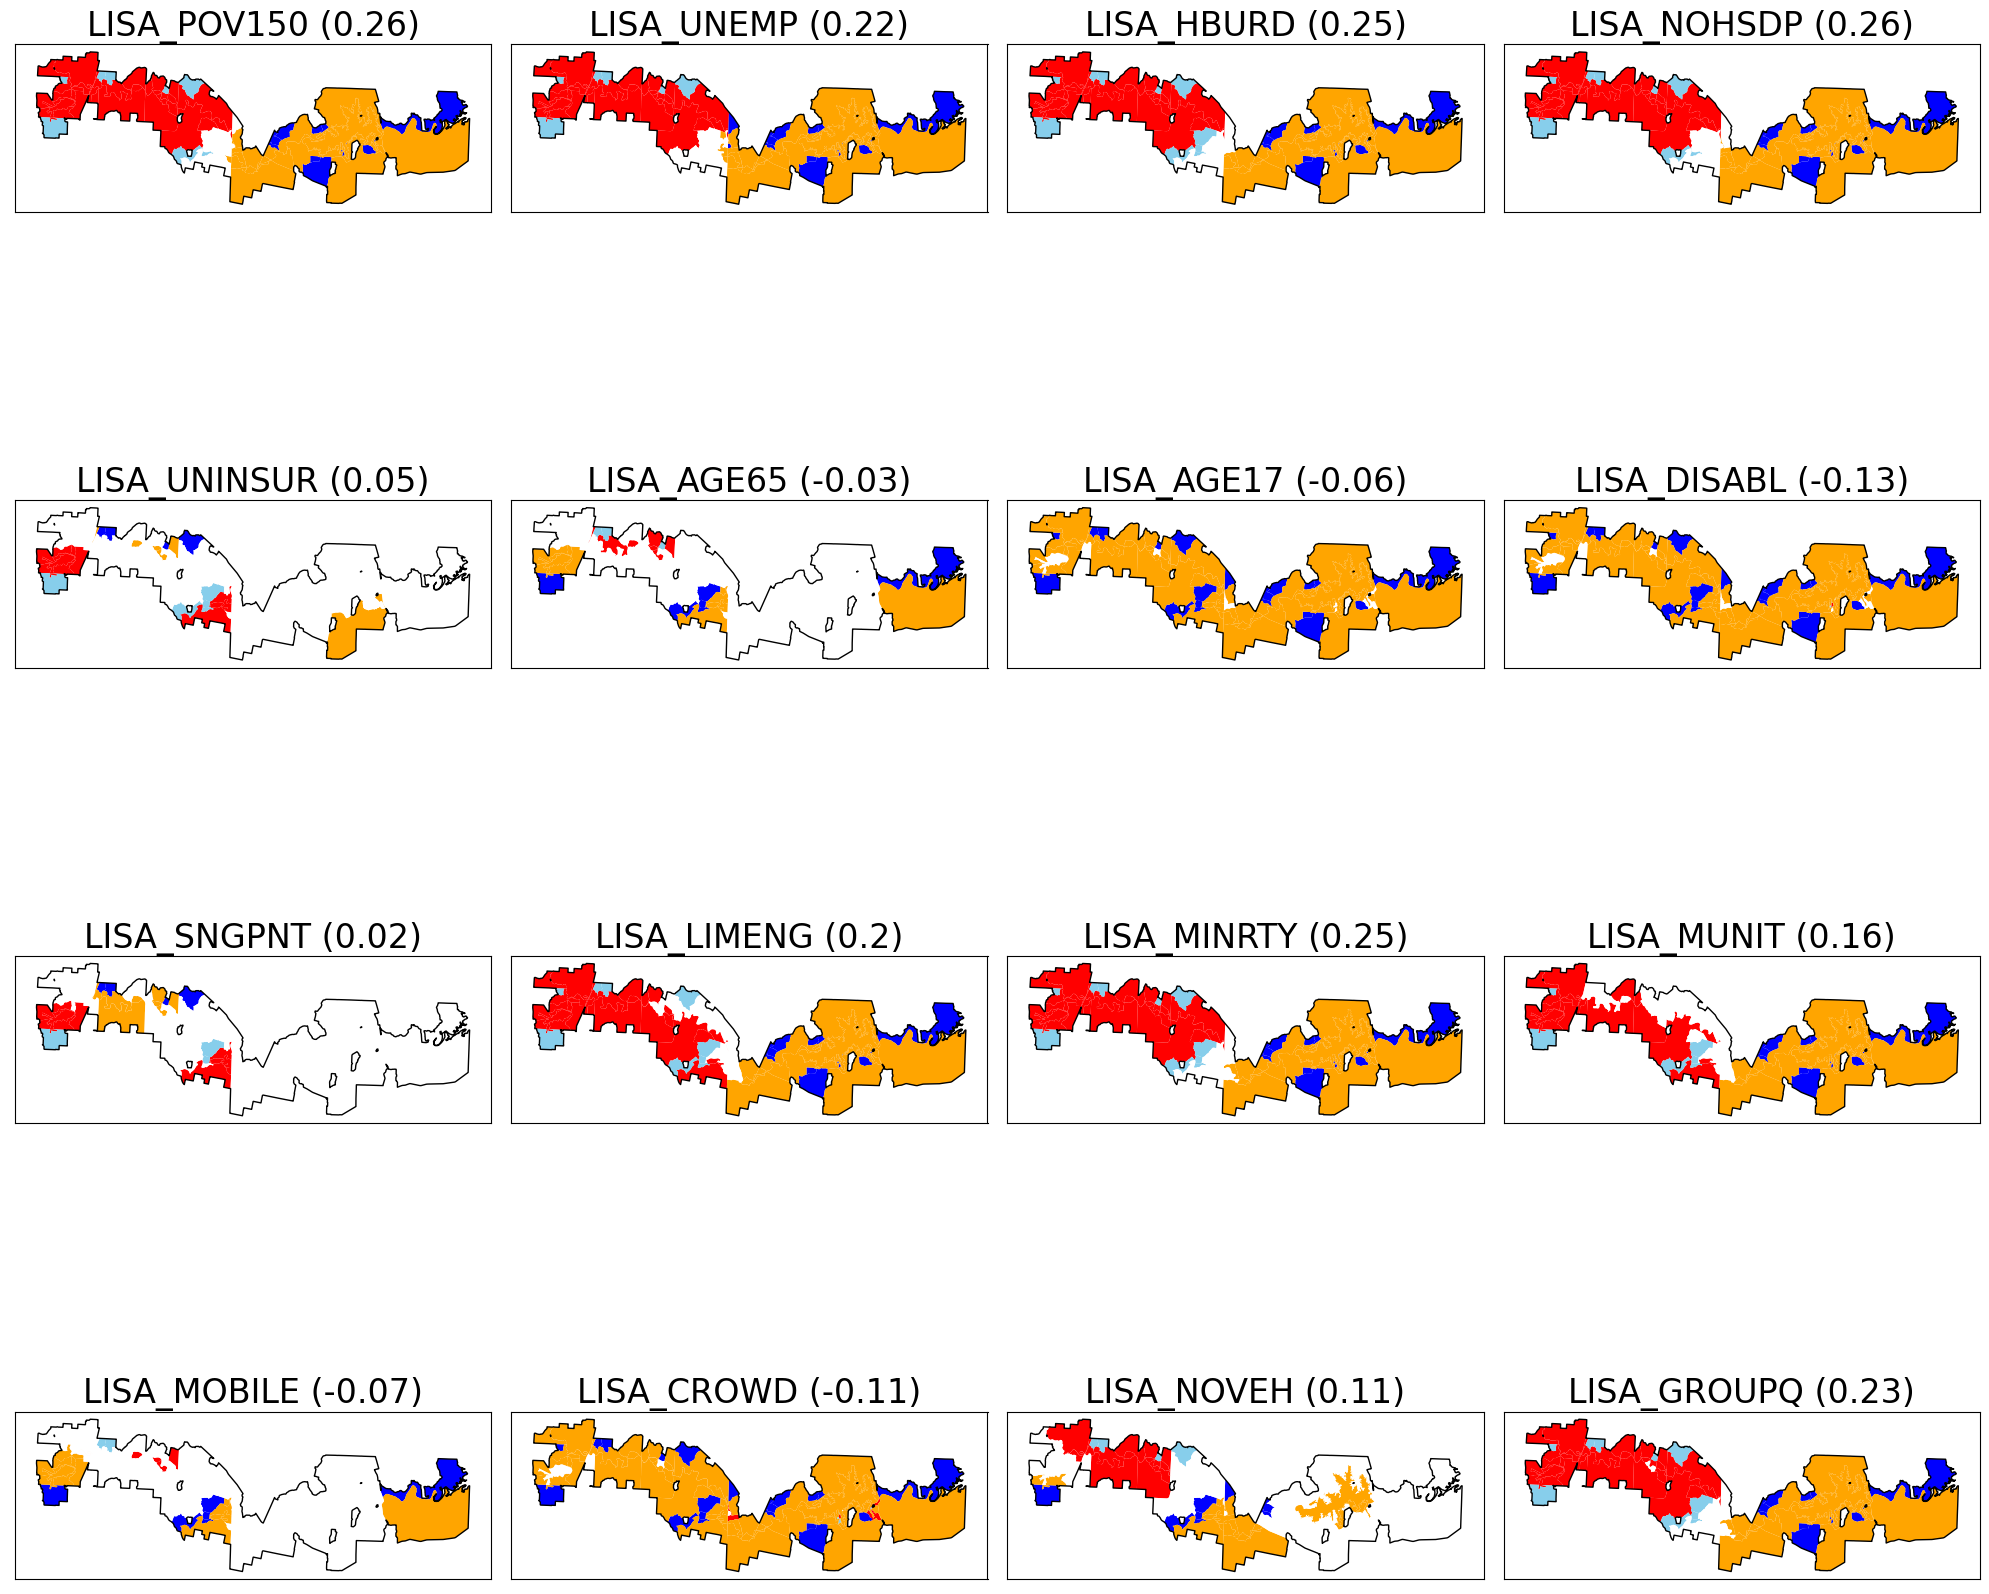

In [34]:
def plot_bivariate_moran_i_and_local_moran_i(dam_id, lm_gdf, mi_gdf):
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = lm_gdf.loc[lm_gdf['Dam_ID'] == dam_id].reset_index()

    inund_area = dam_area.loc[dam_area['Class'] > 0]
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    dam_focus = mi_gdf.loc[mi_gdf['ID'] == dam_id].reset_index()
    dam_focus = dam_focus.to_crs(epsg=5070)

    # Plot maps
    for m in range(16):
        lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}

        for key in lisa_color.keys():
            lm_gdf.loc[(lm_gdf[f'{plot_cols_lm[m]}'] == key) & (lm_gdf['Dam_ID'] == dam_id)].plot(ax=ax[m], color=lisa_color[key], legend=True)

        ax[m].set_title(label=f"{plot_cols_lm[m]} ({round(dam_focus[plot_cols_mi[m]].values[0], 2)})", fontsize=24)

        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.show()
    
# lm = gpd.read_file(f'./MH_F_Results_1/{iter_num}/MH_F_lm.geojson')
plot_bivariate_moran_i_and_local_moran_i(dam_id, lm_gdf, mi_gdf)